In [57]:
import numpy as np
import pandas as pd
import datetime
import pandas as pd
from pandas import DataFrame
import dateutil.parser
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
# from preprocess import train_test_split
# from preprocess import n_series

In [58]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [59]:
file_path = "/home/rahul/Downloads/bharat/time_series1/4200_C005_2019_03_03.tsv"

In [60]:
df = pd.read_csv(file_path, sep=',', header=None)
df.columns = ["kunag", "matnr", "date", "quantity","price"]

In [61]:
import numpy as np
import pandas as pd
import datetime


def n_series(input_df,kunag,matnr):
    input_df = input_df[input_df["quantity"] >=0]    
    df = input_df.copy()
    n_df1 = df[(df["kunag"] == kunag) & (df["matnr"] == matnr)]
    n_df1.date = n_df1.date.apply(lambda x : pd.to_datetime(x,format = '%Y%m%d', errors='ignore'))
    n_df1 = n_df1.sort_values('date')
    n_df1.set_index('date',inplace=True)
    weekly_resampled_data = n_df1.quantity.resample('W').sum() 
    weekly_resampled_data = weekly_resampled_data.replace(np.nan, 0)
    individual_series = weekly_resampled_data.to_frame()
    dataset = individual_series.values
    dataset = dataset.astype('float32')
    # normalize the dataset
#     scaler = MinMaxScaler(feature_range=(0, 1))
#     dataset = scaler.fit_transform(dataset)
#     individual_series = individual_series.reset_index()
    return dataset


def train_test_split(input_df,kunag,matnr,i):
    data= n_series(input_df,kunag,matnr)
    train = data[0:-i]    
    test = data[-i:-1]
    return train,test

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)


In [62]:
n_series(df,500056565, 100278)
# lstm(df,500056565, 100278,16)

/home/rahul/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


array([[ 1.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 4.],
       [ 0.],
       [ 4.],
       [ 0.],
       [ 0.],
       [ 3.],
       [ 0.],
       [ 4.],
       [ 3.],
       [ 3.],
       [ 0.],
       [ 5.],
       [ 3.],
       [ 0.],
       [ 3.],
       [ 4.],
       [ 0.],
       [ 3.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 2.],
       [ 0.],
       [ 2.],
       [ 0.],
       [ 2.],
       [ 0.],
       [ 0.],
       [ 2.],
       [ 0.],
       [ 1.],
       [ 5.],
       [ 8.],
       [ 0.],
       [ 0.],
       [ 8.],
       [10.],
       [ 4.],
       [ 5.],
       [ 0.],
       [ 0.],
       [ 4.],
       [ 2.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 4.],
       [ 0.],
      

In [63]:
def lstm(input_df, kunag,matnr,n):
    dataset = n_series(input_df,kunag,matnr)
    i = 0
    lst = []
    test1 = train_test_split(df,kunag,matnr,n)[1]
    y_hat_avg = test1.copy()
    for i in range(n,3,-1):
        print("count :",i)
        
        train,test = train_test_split(df,kunag,matnr,i)
        scaler = MinMaxScaler(feature_range=(0, 1))
        train = scaler.fit_transform(train)
        test = scaler.fit_transform(test)

        # reshape into X=t and Y=t+1
        look_back = 1
#         print(train)
        trainX, trainY = create_dataset(train, look_back)
        testX, testY = create_dataset(test, look_back)
        # reshape input to be [samples, time steps, features]
        trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
        testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
        
        print(trainX)
        print("||||||||||||||||||||||||||")
        print(testX)
        # create and fit the LSTM network
        model = Sequential()
        model.add(LSTM(4, input_shape=(1, look_back)))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
        
        # make predictions
        trainPredict = model.predict(trainX)

        testPredict = model.predict(testX)
        # invert predictions
        trainPredict = scaler.inverse_transform(trainPredict)
        trainY = scaler.inverse_transform([trainY])
        testPredict = scaler.inverse_transform(testPredict)
        testY = scaler.inverse_transform([testY])
        # calculate root mean squared error
        trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
        print('Train Score: %.2f RMSE' % (trainScore))
        testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
        print('Test Score: %.2f RMSE' % (testScore))

        # shift train predictions for plotting
        trainPredictPlot = numpy.empty_like(dataset)
        trainPredictPlot[:, :] = numpy.nan
        trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
        # shift test predictions for plotting
        testPredictPlot = numpy.empty_like(dataset)
        testPredictPlot[:, :] = numpy.nan
        testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-2, :] = testPredict
        # plot baseline and predictions
        plt.figure(figsize=(12,8))

        plt.plot(scaler.inverse_transform(dataset))
        plt.plot(trainPredictPlot)
        plt.plot(testPredictPlot)
        plt.show()


        break
        
        
    return 


In [64]:
def lstm1(input_df, kunag,matnr,n):
    dataset = n_series(input_df,kunag,matnr)
    i = 0
    lst = []
    test1 = train_test_split(df,kunag,matnr,n)[1]
    y_hat_avg = test1.copy()
    for i in range(n,3,-1):
        print("count :",i)
#         scaler = MinMaxScaler(feature_range=(0, 1))

        train,test = train_test_split(df,kunag,matnr,i)
        scaler = MinMaxScaler(feature_range=(0, 1))
        train = scaler.fit_transform(train)
        test = scaler.fit_transform(test)

        # reshape into X=t and Y=t+1
        look_back = 3
#         print(train)
        

        trainX, trainY = create_dataset(train, look_back)
        testX, testY = create_dataset(test, look_back)
        # reshape input to be [samples, time steps, features]
        trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
        testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
        # create and fit the LSTM network
        model = Sequential()
        model.add(LSTM(4, input_shape=(1, look_back)))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)
        # make predictions
        trainPredict = model.predict(trainX)
        testPredict = model.predict(testX)
        # invert predictions
        trainPredict = scaler.inverse_transform(trainPredict)
        trainY = scaler.inverse_transform([trainY])
        testPredict = scaler.inverse_transform(testPredict)
        testY = scaler.inverse_transform([testY])
        # calculate root mean squared error
        trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
        print('Train Score: %.2f RMSE' % (trainScore))
        testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
        print('Test Score: %.2f RMSE' % (testScore))
        # shift train predictions for plotting
        # shift train predictions for plotting
        trainPredictPlot = numpy.empty_like(dataset)
        trainPredictPlot[:, :] = numpy.nan
        trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
        # shift test predictions for plotting
        testPredictPlot = numpy.empty_like(dataset)
        testPredictPlot[:, :] = numpy.nan
        testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-2, :] = testPredict
        # plot baseline and predictions
        plt.figure(figsize=(12,8))

        plt.plot(scaler.inverse_transform(dataset))
        plt.plot(trainPredictPlot)
        plt.plot(testPredictPlot)
        plt.show()
        break


    return 


/home/rahul/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/rahul/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


count : 16


/home/rahul/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Epoch 1/10
 - 3s - loss: 0.0537
Epoch 2/10
 - 0s - loss: 0.0438
Epoch 3/10
 - 0s - loss: 0.0418
Epoch 4/10
 - 0s - loss: 0.0415
Epoch 5/10
 - 0s - loss: 0.0416
Epoch 6/10
 - 0s - loss: 0.0414
Epoch 7/10
 - 0s - loss: 0.0416
Epoch 8/10
 - 0s - loss: 0.0413
Epoch 9/10
 - 0s - loss: 0.0414
Epoch 10/10
 - 0s - loss: 0.0412
Train Score: 0.61 RMSE
Test Score: 1.06 RMSE


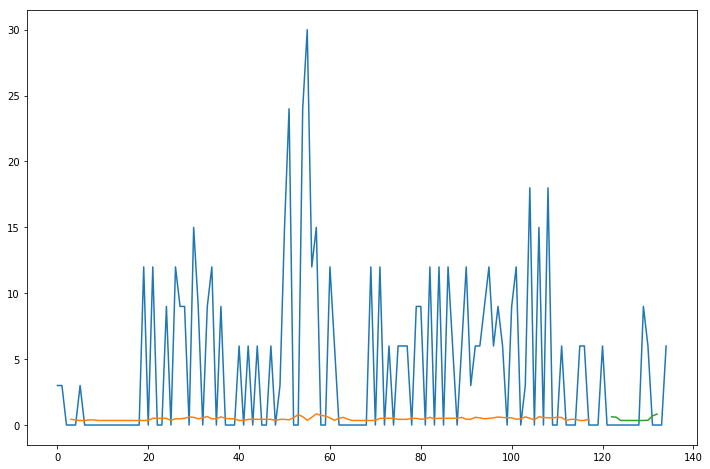

In [65]:


lstm1(df,500056565, 100278,16)

In [55]:
def lstm(input_df, kunag,matnr,n):
    dataset = n_series(input_df,kunag,matnr)
    i = 0
    lst = []
    test1 = train_test_split(df,kunag,matnr,n)[1]
    y_hat_avg = test1.copy()
    for i in range(n,3,-1):
        print("count :",i)
        scaler = MinMaxScaler(feature_range=(0, 1))

        train,test = train_test_split(df,kunag,matnr,i)
        scaler = MinMaxScaler(feature_range=(0, 1))
        train = scaler.fit_transform(train)
        test = scaler.fit_transform(test)

        # reshape into X=t and Y=t+1
        look_back = 1
#         print(train)
        trainX, trainY = create_dataset(train, look_back)
        testX, testY = create_dataset(test, look_back)
        # reshape input to be [samples, time steps, features]
        trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
        testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
        # create and fit the LSTM network
        model = Sequential()
        model.add(LSTM(4, input_shape=(1, look_back)))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)
        
        # make predictions
        trainPredict = model.predict(trainX)
        print(trainPredict)
        testPredict = model.predict(testX)
        # invert predictions
        trainPredict = scaler.inverse_transform(trainPredict)
        trainY = scaler.inverse_transform([trainY])
        testPredict = scaler.inverse_transform(testPredict)
        testY = scaler.inverse_transform([testY])
        # calculate root mean squared error
        trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
        print('Train Score: %.2f RMSE' % (trainScore))
        testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
        print('Test Score: %.2f RMSE' % (testScore))
#         print("trainPredict : ",trainPredict)
        print("testPredict :", testPredict)
        print("--1 : ",testPredict[-1])
        lst.append(testPredict[-1])
        print(lst)


    print(lst)
    # shift train predictions for plotting
    trainPredictPlot = numpy.empty_like(dataset)
    trainPredictPlot[:, :] = numpy.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = numpy.empty_like(dataset)
    testPredictPlot[:, :] = numpy.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    # plot baseline and predictions
    plt.figure(figsize=(12,8))

    plt.plot(scaler.inverse_transform(dataset))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()

        

#         y_hat_avg['SES'] = fit2.forecast(len(test1))
#         pred = y_hat_avg['SES']
#         lst.append(pred.iloc[-1])

#     pd.DataFrame(lst)
#     y_hat_avg['pred_column']=lst
#     rms = sqrt(mean_squared_error(test1.quantity, y_hat_avg.pred_column))
#     mae = mean_absolute_error(test1.quantity, y_hat_avg.pred_column)
#     del y_hat_avg['SES']
    return 


In [56]:
lstm(df,500056565, 100278,16)

/home/rahul/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/rahul/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


count : 16


/home/rahul/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Epoch 1/10
 - 3s - loss: 0.0522
Epoch 2/10
 - 0s - loss: 0.0435
Epoch 3/10
 - 0s - loss: 0.0428
Epoch 4/10
 - 0s - loss: 0.0430
Epoch 5/10
 - 0s - loss: 0.0427
Epoch 6/10
 - 0s - loss: 0.0428
Epoch 7/10
 - 0s - loss: 0.0428
Epoch 8/10
 - 0s - loss: 0.0430
Epoch 9/10
 - 0s - loss: 0.0427
Epoch 10/10
 - 0s - loss: 0.0427
[[0.1516069 ]
 [0.1516069 ]
 [0.14037937]
 [0.14037937]
 [0.14037937]
 [0.1516069 ]
 [0.14037937]
 [0.14037937]
 [0.14037937]
 [0.14037937]
 [0.14037937]
 [0.14037937]
 [0.14037937]
 [0.14037937]
 [0.14037937]
 [0.14037937]
 [0.14037937]
 [0.14037937]
 [0.14037937]
 [0.18092528]
 [0.14037937]
 [0.18092528]
 [0.14037937]
 [0.14037937]
 [0.17189485]
 [0.14037937]
 [0.18092528]
 [0.17189485]
 [0.17189485]
 [0.14037937]
 [0.18920213]
 [0.17189485]
 [0.14037937]
 [0.17189485]
 [0.18092528]
 [0.14037937]
 [0.17189485]
 [0.14037937]
 [0.14037937]
 [0.14037937]
 [0.16211793]
 [0.14037937]
 [0.16211793]
 [0.14037937]
 [0.16211793]
 [0.14037937]
 [0.14037937]
 [0.16211793]
 [0.140

ValueError: could not broadcast input array from shape (13,1) into shape (14,1)

In [8]:
from pandas import Series
from matplotlib import pyplot
from pandas.plotting import lag_plot
df1 = n_series(df,500056565, 100278)
# df1 = df1.set_index('date',inplace=True)
# df1
# lag_plot(df1)
# pyplot.show()

/home/rahul/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [85]:
df1.set_index('date',inplace=True)
df1.head()

,quantity
date,
2016-07-24,1.0
2016-07-31,1.0
2016-08-07,0.0
2016-08-14,0.0
2016-08-21,0.0


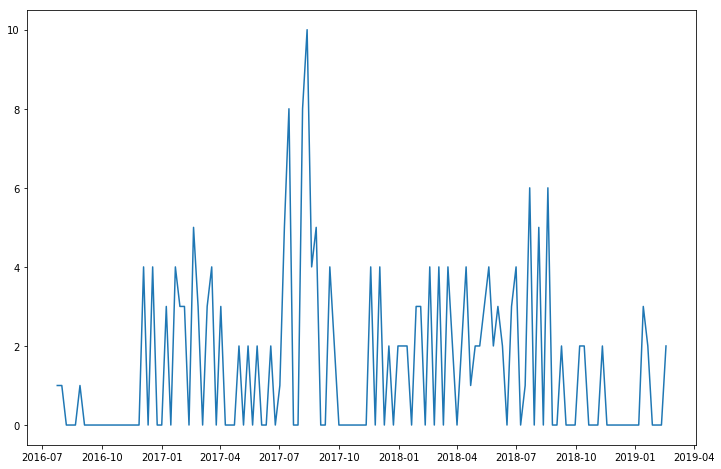

In [86]:
plt.figure(figsize=(12,8))

plt.plot(df1)
plt.show()

In [87]:
dataset = df1.values
dataset = dataset.astype('float32')

In [88]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [89]:
print(len(dataset))

135


In [90]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

90 45


In [91]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [92]:
print(train)

[[0.1]
 [0.1]
 [0. ]
 [0. ]
 [0. ]
 [0.1]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0.4]
 [0. ]
 [0.4]
 [0. ]
 [0. ]
 [0.3]
 [0. ]
 [0.4]
 [0.3]
 [0.3]
 [0. ]
 [0.5]
 [0.3]
 [0. ]
 [0.3]
 [0.4]
 [0. ]
 [0.3]
 [0. ]
 [0. ]
 [0. ]
 [0.2]
 [0. ]
 [0.2]
 [0. ]
 [0.2]
 [0. ]
 [0. ]
 [0.2]
 [0. ]
 [0.1]
 [0.5]
 [0.8]
 [0. ]
 [0. ]
 [0.8]
 [1. ]
 [0.4]
 [0.5]
 [0. ]
 [0. ]
 [0.4]
 [0.2]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0. ]
 [0.4]
 [0. ]
 [0.4]
 [0. ]
 [0.2]
 [0. ]
 [0.2]
 [0.2]
 [0.2]
 [0. ]
 [0.3]
 [0.3]
 [0. ]
 [0.4]
 [0. ]
 [0.4]
 [0. ]
 [0.4]
 [0.2]
 [0. ]
 [0.2]]


In [61]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [62]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [63]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 1s - loss: 0.0655
Epoch 2/100
 - 0s - loss: 0.0523
Epoch 3/100
 - 0s - loss: 0.0481
Epoch 4/100
 - 0s - loss: 0.0467
Epoch 5/100
 - 0s - loss: 0.0463
Epoch 6/100
 - 0s - loss: 0.0461
Epoch 7/100
 - 0s - loss: 0.0458
Epoch 8/100
 - 0s - loss: 0.0457
Epoch 9/100
 - 0s - loss: 0.0456
Epoch 10/100
 - 0s - loss: 0.0453
Epoch 11/100
 - 0s - loss: 0.0452
Epoch 12/100
 - 0s - loss: 0.0452
Epoch 13/100
 - 0s - loss: 0.0448
Epoch 14/100
 - 0s - loss: 0.0447
Epoch 15/100
 - 0s - loss: 0.0447
Epoch 16/100
 - 0s - loss: 0.0445
Epoch 17/100
 - 0s - loss: 0.0445
Epoch 18/100
 - 0s - loss: 0.0448
Epoch 19/100
 - 0s - loss: 0.0443
Epoch 20/100
 - 0s - loss: 0.0444
Epoch 21/100
 - 0s - loss: 0.0444
Epoch 22/100
 - 0s - loss: 0.0444
Epoch 23/100
 - 0s - loss: 0.0440
Epoch 24/100
 - 0s - loss: 0.0443
Epoch 25/100
 - 0s - loss: 0.0439
Epoch 26/100
 - 0s - loss: 0.0439
Epoch 27/100
 - 0s - loss: 0.0439
Epoch 28/100
 - 0s - loss: 0.0439
Epoch 29/100
 - 0s - loss: 0.0441
Epoch 30/100
 - 0s - lo

In [64]:
# make predictions
trainPredict = model.predict(trainX)

testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))





Train Score: 2.07 RMSE
Test Score: 1.77 RMSE


In [68]:
print(len(trainPredict))

88


In [69]:
print(len(testPredict))

43


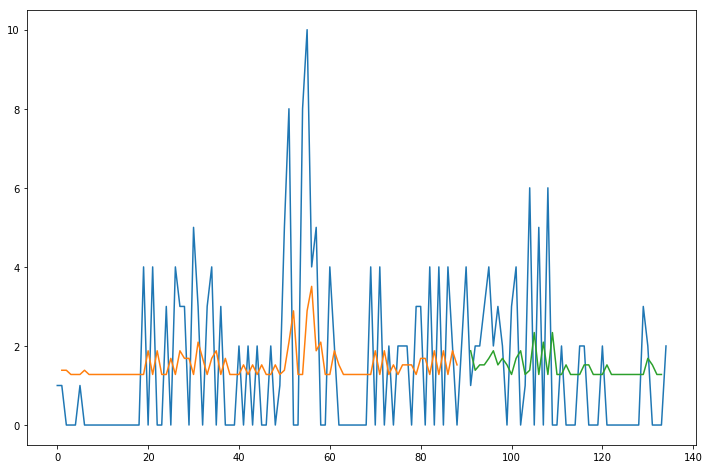

In [36]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(12,8))

plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
import os, sys
import time
start = time.time()
bucket = pd.read_csv("bucket.csv")
df = pd.read_csv("4200_C005_2019_03_03.tsv", sep=',', header=None)
df.columns = ["kunag", "matnr", "date", "quantity","price"]


folder = 'model_graphs/'+"comp(MA7.8.9)(1-1001)"
if not os.path.exists(folder):
        os.makedirs(folder)
n = 16
cnt = 0


main_df = pd.DataFrame(columns =["kunag","matnr","mae(MA7)","mae(MA8)","mae(MA9)"])
main_df1 = pd.DataFrame(columns =["kunag","matnr","rms(MA7)","rms(MA8)","rms(MA9)"])

for i in range (1,10):
            kunag = int(bucket["kunag"].iloc[i])
            matnr = int(bucket["matnr"].iloc[i])
            index = str(kunag) +"_"+ str(matnr)
            cnt+=1
            print("count",cnt)
            print("index : ",index)
            


            result_df = pd.DataFrame(OrderedDict({"kunag" : [kunag],"matnr" : [matnr],
                       "mae(MA7)" : [round(mae1,3)],
                       "mae(MA8)" : [round(mae2,3)],
                       "mae(MA9)" : [round(mae3,3)]}))

#             print(result_df)
            main_df = main_df.append(result_df, ignore_index = True)
            main_df1 = main_df.append(result_df1, ignore_index = True)
            export_csv = main_df.to_csv (r'results/MAEcomp(MA7.8.9)(1-1001).csv',sep = ",", index = None, header=True)
            
end = time.time()
print("Time Taken : ",end - start)

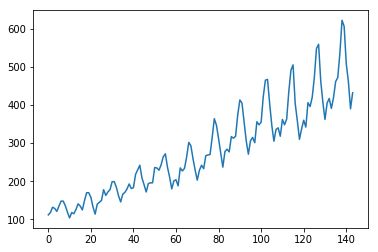

In [18]:
import pandas
import matplotlib.pyplot as plt
%matplotlib inline
dataset = pandas.read_csv('airline-passengers.csv', usecols=[1], engine='python')
plt.plot(dataset)
plt.show()

In [19]:
dataset.head()

,Passengers
0,112
1,118
2,132
3,129
4,121


In [23]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [24]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [5]:
# load the dataset
dataframe = pandas.read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

In [6]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [7]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


In [8]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [9]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [10]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [11]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 1s - loss: 0.0413
Epoch 2/100
 - 0s - loss: 0.0202
Epoch 3/100
 - 0s - loss: 0.0146
Epoch 4/100
 - 0s - loss: 0.0131
Epoch 5/100
 - 0s - loss: 0.0121
Epoch 6/100
 - 0s - loss: 0.0111
Epoch 7/100
 - 0s - loss: 0.0102
Epoch 8/100
 - 0s - loss: 0.0093
Epoch 9/100
 - 0s - loss: 0.0081
Epoch 10/100
 - 0s - loss: 0.0071
Epoch 11/100
 - 0s - loss: 0.0062
Epoch 12/100
 - 0s - loss: 0.0053
Epoch 13/100
 - 0s - loss: 0.0045
Epoch 14/100
 - 0s - loss: 0.0038
Epoch 15/100
 - 0s - loss: 0.0033
Epoch 16/100
 - 0s - loss: 0.0029
Epoch 17/100
 - 0s - loss: 0.0026
Epoch 18/100
 - 0s - loss: 0.0024
Epoch 19/100
 - 0s - loss: 0.0022
Epoch 20/100
 - 0s - loss: 0.0022
Epoch 21/100
 - 0s - loss: 0.0021
Epoch 22/100
 - 0s - loss: 0.0021
Epoch 23/100
 - 0s - loss: 0.0021
Epoch 24/100
 - 0s - loss: 0.0021
Epoch 25/100
 - 0s - loss: 0.0020
Epoch 26/100
 - 0s - loss: 0.0021
Epoch 27/100
 - 0s - loss: 0.0020
Epoch 28/100
 - 0s - loss: 0.0020
Epoch 29/100
 - 0s - loss: 0.0020
Epoch 30/100
 - 0s - lo

In [12]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 22.92 RMSE
Test Score: 47.53 RMSE


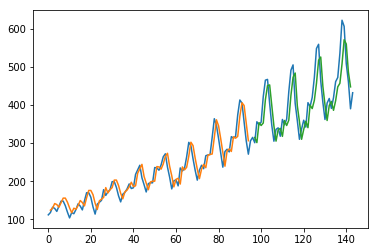

In [13]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Epoch 1/100
 - 1s - loss: 0.0542
Epoch 2/100
 - 0s - loss: 0.0259
Epoch 3/100
 - 0s - loss: 0.0167
Epoch 4/100
 - 0s - loss: 0.0145
Epoch 5/100
 - 0s - loss: 0.0129
Epoch 6/100
 - 0s - loss: 0.0116
Epoch 7/100
 - 0s - loss: 0.0105
Epoch 8/100
 - 0s - loss: 0.0094
Epoch 9/100
 - 0s - loss: 0.0081
Epoch 10/100
 - 0s - loss: 0.0074
Epoch 11/100
 - 0s - loss: 0.0066
Epoch 12/100
 - 0s - loss: 0.0060
Epoch 13/100
 - 0s - loss: 0.0056
Epoch 14/100
 - 0s - loss: 0.0052
Epoch 15/100
 - 0s - loss: 0.0050
Epoch 16/100
 - 0s - loss: 0.0049
Epoch 17/100
 - 0s - loss: 0.0046
Epoch 18/100
 - 0s - loss: 0.0045
Epoch 19/100
 - 0s - loss: 0.0045
Epoch 20/100
 - 0s - loss: 0.0043
Epoch 21/100
 - 0s - loss: 0.0043
Epoch 22/100
 - 0s - loss: 0.0042
Epoch 23/100
 - 0s - loss: 0.0042
Epoch 24/100
 - 0s - loss: 0.0042
Epoch 25/100
 - 0s - loss: 0.0040
Epoch 26/100
 - 0s - loss: 0.0041
Epoch 27/100
 - 0s - loss: 0.0040
Epoch 28/100
 - 0s - loss: 0.0040
Epoch 29/100
 - 0s - loss: 0.0039
Epoch 30/100
 - 0s - lo

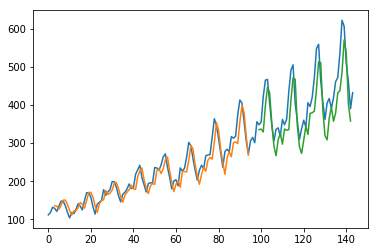

In [14]:
# LSTM for international airline passengers problem with window regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [15]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

ValueError: cannot reshape array of size 276 into shape (92,1,1)

Epoch 1/100
 - 1s - loss: 0.0285
Epoch 2/100
 - 0s - loss: 0.0117
Epoch 3/100
 - 0s - loss: 0.0097
Epoch 4/100
 - 0s - loss: 0.0086
Epoch 5/100
 - 0s - loss: 0.0074
Epoch 6/100
 - 0s - loss: 0.0065
Epoch 7/100
 - 0s - loss: 0.0058
Epoch 8/100
 - 0s - loss: 0.0053
Epoch 9/100
 - 0s - loss: 0.0045
Epoch 10/100
 - 0s - loss: 0.0044
Epoch 11/100
 - 0s - loss: 0.0041
Epoch 12/100
 - 0s - loss: 0.0041
Epoch 13/100
 - 0s - loss: 0.0040
Epoch 14/100
 - 0s - loss: 0.0039
Epoch 15/100
 - 0s - loss: 0.0039
Epoch 16/100
 - 0s - loss: 0.0039
Epoch 17/100
 - 0s - loss: 0.0038
Epoch 18/100
 - 0s - loss: 0.0039
Epoch 19/100
 - 0s - loss: 0.0038
Epoch 20/100
 - 0s - loss: 0.0038
Epoch 21/100
 - 0s - loss: 0.0038
Epoch 22/100
 - 0s - loss: 0.0038
Epoch 23/100
 - 0s - loss: 0.0037
Epoch 24/100
 - 0s - loss: 0.0038
Epoch 25/100
 - 0s - loss: 0.0037
Epoch 26/100
 - 0s - loss: 0.0038
Epoch 27/100
 - 0s - loss: 0.0037
Epoch 28/100
 - 0s - loss: 0.0038
Epoch 29/100
 - 0s - loss: 0.0037
Epoch 30/100
 - 0s - lo

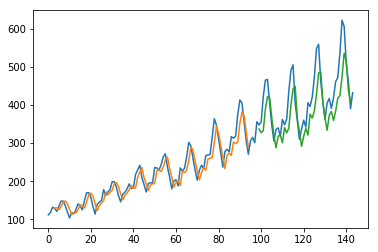

In [16]:
# LSTM for international airline passengers problem with time step regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:

    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    # reshape input to be [samples, time steps, features]
    trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(4, input_shape=(look_back, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    # shift train predictions for plotting
    trainPredictPlot = numpy.empty_like(dataset)
    trainPredictPlot[:, :] = numpy.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = numpy.empty_like(dataset)
    testPredictPlot[:, :] = numpy.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    # plot baseline and predictions
    plt.figure(figsize=(12,8))
    plt.plot(scaler.inverse_transform(dataset))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()